In [ ]:
%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import zscore
import scipy.cluster.hierarchy as ch
from sklearn.cluster import AgglomerativeClustering

CPU times: user 6 μs, sys: 1 μs, total: 7 μs
Wall time: 10.3 μs


## Clustering

Lets see if we can find some hidden patterns using different clustering models!

### Data cleaning

In [3]:
df = pd.read_csv("coffee_quality.csv")
df.head()

,quality_score,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Moisture,Category Two Defects
0,90.58,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,0.12,0
1,89.92,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,0.12,1
2,89.75,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,0.00,0
3,89.00,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,0.11,2
4,88.83,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,0.12,2


In [4]:
df.isna().sum()

quality_score           0
Aroma                   0
Flavor                  0
Aftertaste              0
Acidity                 0
Body                    0
Balance                 0
Uniformity              0
Clean Cup               0
Sweetness               0
Moisture                0
Category Two Defects    0
dtype: int64

### Data exploration

In [5]:
df.describe()

,quality_score,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Moisture,Category Two Defects
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000
mean,82.086212,7.562614,7.516913,7.396822,7.532614,7.516570,7.516349,9.825899,9.825625,9.895724,0.088796,3.589177
std,3.675542,0.380976,0.402017,0.406202,0.381879,0.361512,0.408316,0.621552,0.817449,0.596925,0.048001,5.349249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81.170000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.000000,10.000000,0.090000,0.000000
50%,82.500000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.000000,10.000000,10.000000,0.110000,2.000000
75%,83.670000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.000000,10.000000,0.120000,4.000000
max,90.580000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.000000,10.000000,0.280000,55.000000


<Axes: >

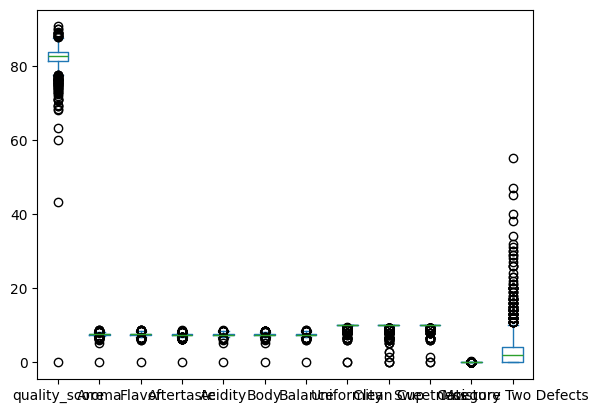

In [6]:
df.plot.box()

It seems that our dataset is clean in terms of missing values. All attributes except the target "quality_score", is following a skewed normal distribution with a lot of outliers, which we will have to take into account when training models.

In [7]:
# Lets drop our target feature, as we are interested in finding new relations
df = df.drop('quality_score', axis=1)

In [8]:
# scale data points for weighing features evenly when doing PCA
# df[df.columns] = sk.preprocessing.StandardScaler().fit_transform(df)
df[df.columns] = sk.preprocessing.RobustScaler().fit_transform(df) # Robustscaler because of outliers


In [9]:
df.describe()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Moisture,Category Two Defects
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000
mean,-0.052684,-0.150207,-0.070237,0.077653,0.048736,0.038926,-0.174101,-0.174375,-0.104276,-0.706809,0.397294
std,1.154473,0.957184,1.230914,0.909236,1.063272,0.972181,0.621552,0.817449,0.596925,1.600041,1.337312
min,-22.969697,-18.047619,-22.484848,-17.857143,-22.058824,-17.857143,-10.000000,-10.000000,-10.000000,-3.666667,-0.500000
25%,-0.484848,-0.595238,-0.515152,-0.404762,-0.500000,-0.404762,0.000000,0.000000,0.000000,-0.666667,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.515152,0.404762,0.484848,0.595238,0.500000,0.595238,0.000000,0.000000,0.000000,0.333333,0.500000
max,3.545455,2.976190,3.787879,2.976190,3.176471,2.976190,0.000000,0.000000,0.000000,5.666667,13.250000


In [10]:
# Lets see how much variance we can preserve by reducing the dataset to 2d
pca = PCA()
pca.fit(df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
cumulative_variance[1]

np.float64(0.6777584889734083)

/tmp/ipykernel_2108/3103998374.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


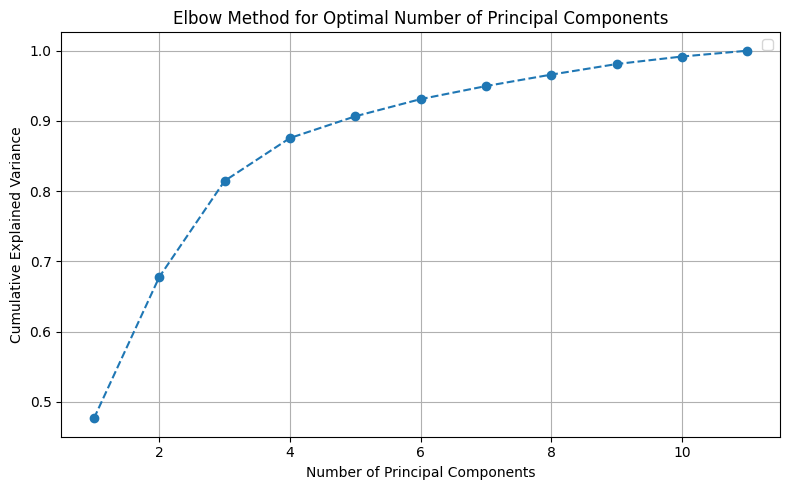

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Optimal Number of Principal Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# So we can retain 66% of the variance with 2 components. pretty good!
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df)
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df.columns, index=['PC_1', 'PC_2'])
dataset_pca

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Moisture,Category Two Defects
PC_1,0.411397,0.365345,0.472885,0.318574,0.372012,0.35554,0.119168,0.155154,0.101467,0.190690,0.149778
PC_2,0.106543,0.086356,0.078519,0.080459,0.068190,0.03675,0.083423,0.084587,0.091247,0.952298,0.182319


Here we see the result of our PCA processing. PCA 1 is mainly weightd by Aroma, flavor, Aftertaste Acidity and balance. PCA 2 Is especially weighted by Moisture!

<Axes: >

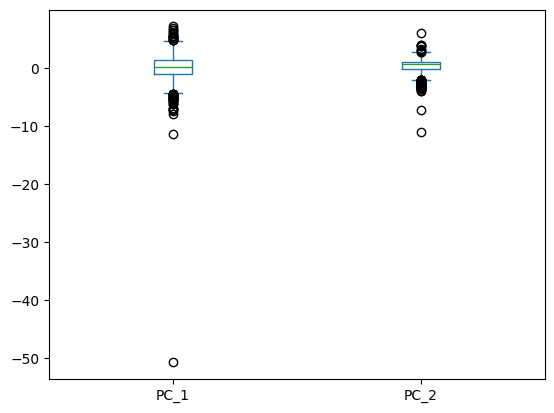

In [13]:
df_pca = pd.DataFrame(pca_2_result, columns=['PC_1', 'PC_2'])
df_pca.plot.box()

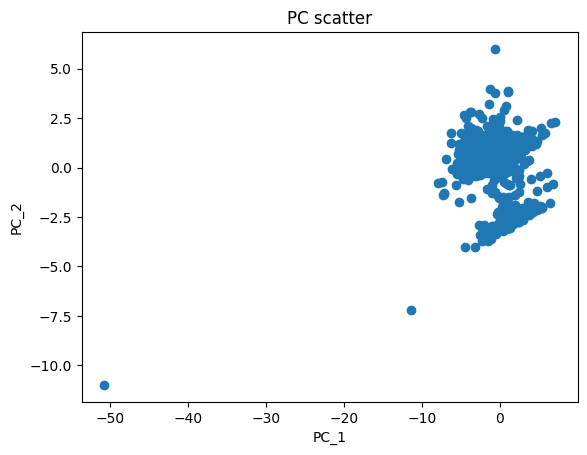

In [14]:
plt.title('PC scatter')
plt.scatter(df_pca['PC_1'], df_pca['PC_2'])
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.show()

Again the data points follow a normal distribution, but there seems to be some serious outliers present!

In [15]:
# Drop outlying rows
z_scores = np.abs(zscore(df_pca))
df_pca = df_pca[(z_scores < 3).all(axis=1)]

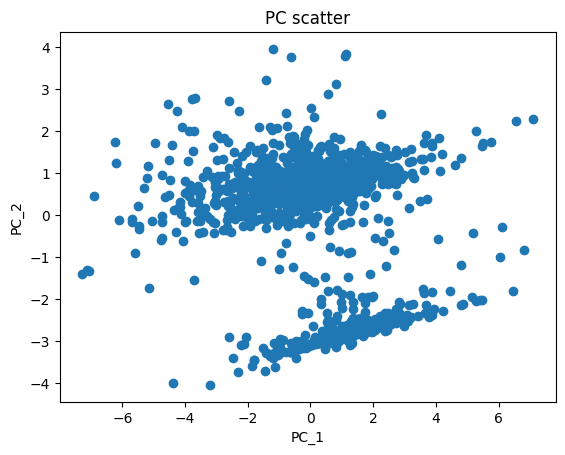

In [16]:
plt.title('PC scatter')
plt.scatter(df_pca['PC_1'], df_pca['PC_2'])
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.show()

So here is our 2D data points!

In [17]:
# Calculating optimal number of clusters in a K-means algorithm using silhouette score
#scores = pd.DataFrame(columns=['num_clusters', 's_score'])
scores = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(df_pca)
    score = sk.metrics.silhouette_score(df_pca, model.labels_, metric='euclidean', sample_size=len(df_pca))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append([k, score])


Number of clusters = 2
Silhouette score = 0.5060006111104427

Number of clusters = 3
Silhouette score = 0.4780078817516703

Number of clusters = 4
Silhouette score = 0.45469572674677006

Number of clusters = 5
Silhouette score = 0.42889882519001

Number of clusters = 6
Silhouette score = 0.41860326913043905

Number of clusters = 7
Silhouette score = 0.4159694097595906

Number of clusters = 8
Silhouette score = 0.40779927235239183

Number of clusters = 9
Silhouette score = 0.39340229963888695


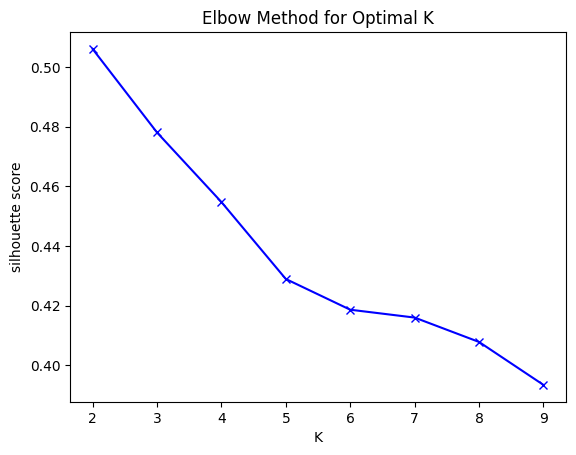

In [18]:
score_df = pd.DataFrame(scores, columns=['k', 'scores'])
plt.title('Elbow Method for Optimal K')
plt.plot(score_df.k, score_df.scores, 'bx-')
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.show()

In [19]:
# Run k-means clustering on the optimal amount of clusters (k)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10) 
prediction = kmeans.fit_predict(df_pca)

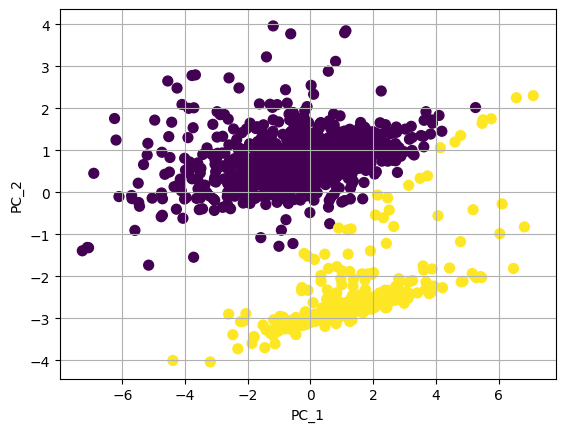

In [20]:
plt.scatter(df_pca['PC_1'], df_pca['PC_2'], c=prediction, s=50, cmap='viridis')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.grid(True)
plt.show()

By running a K-means clustering we can see there seems to be 2 categories of especially PCA 2, which indicates that the coffee beans fall into 2 categories of moisture.
Maybe we can find a more accurate method

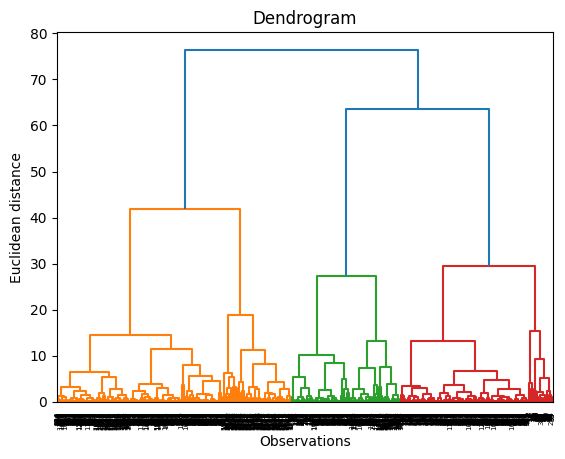

In [21]:
# Dendogram for agglomerative clustering
dendogram = ch.dendrogram(ch.linkage(df_pca, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean distance')
plt.show()

In [22]:
n_clusters = 3
model = AgglomerativeClustering(n_clusters, linkage = 'ward')
aggmodel_pred = model.fit_predict(df_pca)

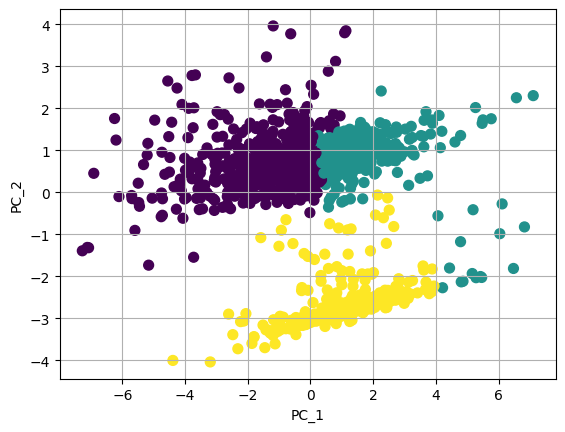

In [23]:
plt.scatter(df_pca['PC_1'], df_pca['PC_2'], c=aggmodel_pred, s=50, cmap='viridis')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.grid(True)
plt.show()

Doesn't really seem better

In [ ]:
#DBSCAN for automatically determining amount of clusters
# Tried to play a little around with eps here
dbscan = DBSCAN(eps=0.4, min_samples=6)
dbscan_pred = dbscan.fit_predict(df_pca)
dbscan_pred

array([-1, -1, -1, ..., -1, -1, -1], shape=(1307,))

/tmp/ipykernel_2108/3863500904.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


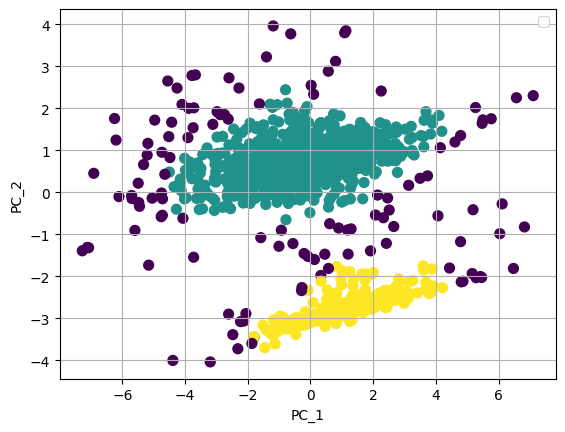

In [46]:
plt.scatter(df_pca['PC_1'], df_pca['PC_2'], c=dbscan_pred, s=50, cmap='viridis')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.grid(True)
plt.legend()
plt.show()

Here we we clearly se the 2 categories. The data points seems to follow a normal distribution in PCA 1, but is divided into 2 categoried in PCA 2. the DBSCAN algorithm identifies the densest parts, and classifies all points around as outliers.